In [1]:
import logging
import uuid

import pandas as pd
import numpy as np
from sqlalchemy import select, func, distinct, or_, and_, union, text
from datetime import date

from nacsos_data.db import get_engine
from nacsos_data.db.schemas.imports import Import, m2m_import_item_table
from nacsos_data.db.schemas.items.academic import AcademicItem, AcademicItemVariant
from nacsos_data.db.schemas.items.base import Item
from nacsos_data.db.schemas import AnnotationScheme, AssignmentScope, Assignment, Annotation, BotAnnotationMetaData, BotAnnotation
from nacsos_data.util.academic.duplicate import str_to_title_slug

db_engine = get_engine(conf_file='/usr/share/nacsos/server.env')

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s: %(message)s', level=logging.INFO)
logger = logging.getLogger('import')
logger.setLevel(logging.DEBUG)

pd.options.display.max_columns = None

PROJECT_ID = '3d761435-fe4f-4829-a33e-26fc52a46613'
SCHEME_ID = '4658a522-0626-4074-b207-ed46ea13d2a1'


JOSEFINE = '45c63ef0-2af7-4652-b096-cff368497fea'
FELIX = '6f57074c-b145-4826-a20c-2aba8939758f'
LYNN = '8049cefa-6f2a-4fed-8b71-ca9424dd99c6'
NIKOLA = '3cd7dc2a-f920-4699-898e-7760ef7fb063'
FREDA = 'c1a5ad43-348a-40ad-a6f5-96df26022ce4'

USERS = {
    'josefine.hintz': JOSEFINE,
    'felix.creutzig': FELIX,
    'lynn.kaack': LYNN,
    'nikola.milojevic': NIKOLA,
    'freda.pachter': FREDA
}
USERS_MAP = {v: k for k, v in USERS.items()}



In [2]:
ASSIGNMENT_SCOPES = [
    'ec384280-a445-43de-b467-2cce7a048391', # Imported from sheet "bikes and scooters" in "AllRecords.xlsx"
    'dbe0545e-68a6-43e5-b08c-8639281b24bb', # Imported from sheet "buildings" in "AllRecords.xlsx"
    '67ec81fe-ebce-438c-8f6e-519b2f4b50ff', # Imported from sheet "transport" in "AllRecords.xlsx"
    'd4e5c1b0-d2c5-4a77-877b-5226ead1f8bf', # Imported from sheet "urban form" in "AllRecords.xlsx"
    '599a1074-cb9f-4ed0-976d-8139633c6e88', # Imported from sheet "waste" in "AllRecords.xlsx"
    '56fe353c-d132-4ce5-8ad9-674c81a22dd0', # 20240715_prioritised_bikes_JH_NM
    'a000c157-2b45-4b7c-b6f1-29b1e4b0c6b2', # 20240715_prioritised_build_JH_NM
    '7841abe6-977f-4617-aa58-477613ae663a', # 20240715_prioritised_trans_JH_NM
    '463c4585-f9b0-477c-92b0-42f022976c2a', # 20240715_prioritised_urban_JH_NM
    '0d57d963-fab3-48ac-bfb0-b4cfb59cedff', # 20240715_prioritised_waste_JH_NM
    '8fc1f9b3-7ed1-4af1-a2d9-8d1744827dac', # 20240715_prioritised_bikes_JH_NM_FC
    '00afa75f-4e1f-49db-b6d3-8a98ad2138c3', # 20240715_prioritised_build_JH_NM_FC
    '145c4809-3d18-482a-81f3-a55ace81ace4', # 20240715_prioritised_trans_JH_NM_FC
    'bbac2f15-ac3d-4ff0-b054-291a7c117a26', # 20240715_prioritised_urban_JH_NM_FC
    '27ed2842-0e23-4bae-88ae-f8b170f80ecc', # 20240715_prioritised_waste_JH_NM_FC
    'c812842c-8e1c-45ba-a8aa-7c26e31066b0', # 20240717_prioritised_bikes_JH_NM_FP
    'f8e62b5d-4b1e-4266-90e8-8475e3fcc70f', # 20240717_prioritised_build_JH_NM_FP
    'ce2dcbd3-5b98-4505-920c-ae0857c5a186', # 20240717_prioritised_trans_JH_NM_FP
    'c15d03ce-3b00-4169-bd1a-58cef9772d72', # 20240717_prioritised_urban_JH_NM_FP
    'b0c734f7-8f27-4d7c-a78c-b7b8f57a3745', # 20240717_prioritised_waste_JH_NM_FP
    '3ce421d9-ccb5-4350-9c26-1b43235b4af8', # 20240718_prioritised_bikes_JH_NM
    'cc836405-0a1e-431b-a6ab-53790a0f2f18', # 20240718_prioritised_build_JH_NM
    '0fd7fba7-2d4d-424e-abc7-4331c40e31b5', # 20240718_prioritised_trans_JH_NM
    '76105c1b-9856-49b4-b6c4-d02df0e5b09b', # 20240718_prioritised_urban_JH_NM
    '0c42fdc0-6456-4125-8dcd-ace58d6768a9', # 20240723_prioritised_bikes_JH_NM
    'c04c4de9-81b8-4ed4-aba4-7c65dd5269ea', # 20240723_prioritised_bikes_JH_NM
    '2788c08a-5058-4cb0-82ce-c92036002fce', # 20240723_prioritised_build_JH_NM
    '8c6f5c67-297c-4282-b39f-18dc796dc8f4', # 20240723_prioritised_build_JH_NM
    '6d3f63d8-3715-4e51-a6ea-c54b8e44962e', # 20240723_prioritised_trans_JH_NM
    'ffe142dd-82a5-416c-90e5-9dcf77265278', # 20240723_prioritised_trans_JH_NM
    'ab27e0fa-1e0b-4e65-83c8-46db15a574ab', # 20240723_prioritised_urban_JH_NM
    'b3be005a-2219-42b8-a3fa-973aea970a15', # 20240723_prioritised_urban_JH_NM
    'f32e33d9-0510-4592-bf58-3dc8efc94a7b', # 2024-08-06_prioritised_bikes
    '234c4402-3dd1-4b30-83d6-c253792421c9', # 2024-08-06_prioritised_build
    '363efd4e-77db-4f0c-ace4-d50a81fd25e8', # 2024-08-06_prioritised_trans
    '6603b4b8-6fda-4970-85cf-c1da304f6e18', # 2024-08-06_prioritised_urban
    '11eb00fc-07f2-4871-8032-5cf77373302c', # 2024-08-09_prioritised_bikes
    '9b5edfc0-2a07-4b5d-8cd1-8225ef3aedd6', # 2024-08-09_prioritised_trans
    '699ae206-5117-49b4-ac3c-37e08516b45e', # 2024-08-09_prioritised_urban
    '2d164a99-12d6-42eb-a6a0-b90a3a2d9a23', # 2024-08-12_prioritised_bikes
    '18a188c9-7dc5-46cb-b111-d5e9338f83cd', # 2024-08-13_prioritised_bikes
    '180fffce-1e62-4724-89e3-ec9cc3734ddd', # 2024-08-13_prioritised_bikes
]
RESOLVED_SCOPES = [
    'be1361b6-35ed-4509-bc2a-da10c9d83e91',  # Resolution for "bikes and scooters"
    'c42b71c7-f1dc-46b2-b187-72fa78f8a397',  # Resolution for "buildings"
    'c77b8462-7ab5-4bac-b686-6008c8fbe727',  # Resolution for "transport"
    '0057dc42-5821-445b-b3d5-834d0958d110',  # Resolution for "urban form"
    'b386ae78-ae35-428a-be34-abceab9dba3f',  # Resolution for "Waste"
    '18ce3c5c-116a-41ce-a343-4fe7964f3c2e',  # Resolved_20240715_prioritised_bikes_JH_NM_done
    'a122bbe1-610c-4f09-91fe-bec96e921a42',  # Resolved_20240715_prioritised_build_JH_NM
    'bd76251c-902d-4f80-bd5a-4a8a86bac673',  # Resolved_20240715_prioritised_trans_JH_NM
    'ead682c1-a2bf-44d2-9ec6-1f2243b17449',  # Resolved_20240715_prioritised_urban_JH_NM
    'b2152ad1-09a1-492b-a0d1-9c6176854ca8',  # Resolved_20240715_prioritised_waste_JH_NM
    '2d99ac7f-0bef-4a24-8fde-f210a8c549a4',  # Resolved_20240717_prioritised_waste_JH_NM_FP
    '78ea4635-2493-48a2-b9e6-04961373b05b',  # 20240715_prioritised_bikes_JH_NM_FC_resolved
    '5865cccb-6dd5-4f7f-8373-683679312569',  # 20240715_prioritised_build_JH_NM_FC_resolved
    'cb311f54-8949-4565-b832-540a19f15729',  # 20240715_prioritised_trans_JH_NM_FC_resolved
    'd57f6215-ed0a-4844-bc93-34df69527378',  # 20240715_prioritised_urban_JH_NM_FC_resolved
    'f20b9f03-79fe-4bc4-a3ad-2c42daa3d6c1',  # 20240715_prioritised_waste_JH_NM_FC_resolved
    'f9b7f8ba-2d79-422f-8f08-b8850eaeb34c',  # 20240717_prioritised_bikes_JH_NM_FP_resolved
    'd187b9bf-0071-41b0-a718-1bd747965418',  # 20240717_prioritised_build_JH_NM_FP_resolved
    'd4356bd7-1aa8-4407-a24d-5b73c6267971',  # 20240717_prioritised_trans_JH_NM_FP_resolved
    '4a075222-6878-4e03-8d0b-dff30200cd69',  # 20240717_prioritised_urban_JH_NM_FP_resolved
    '27b7754a-03c6-4d8d-859f-a8108d2bdb93',  # 20240718_prioritised_bikes_JH_NM_resolved
    '28360d2c-8a8f-4b84-8c1d-7401c8a179f0',  # 20240718_prioritised_build_JH_NM_resolved
    '68d21ba3-0367-4419-85d8-96b182efa87f',  # 20240718_prioritised_trans_JH_NM_resolved
    '00f99d72-5309-4959-9f30-148d63676036',  # 20240718_prioritised_urban_JH_NM_resolved
    'a80742e1-24f5-4f62-8bc8-396377936f40',  # 20240723_prioritised_bikes_JH_NM_resolved
    'b9736537-557f-4a2c-b19b-ed5bdb925151',  # 20240723_prioritised_bikes_JH_NM_resolved
    'a1b8b949-02ee-41e4-a709-401b16d2d3b3',  # 20240723_prioritised_build_JH_NM_resolved
    'cabb283d-15e1-4860-b3a6-4602d112dd20',  # 20240723_prioritised_build_JH_NM_resolved
    '26f13b22-03f9-4408-a566-037de15f95c4',  # 20240723_prioritised_trans_JH_NM_resolved
    '968034f5-0226-4801-a236-3abc4db9559a',  # 20240723_prioritised_trans_JH_NM_resolved
    '63f56741-2cb8-4574-a364-29e2e48040d3',  # 20240723_prioritised_urban_JH_NM_resolved
    '1e1039e1-2cde-4eea-8d5e-cba18eabab10',  # 20240723_prioritised_urban_JH_NM_resolved
    '4ecc20be-d16a-43b1-9c1c-09c28003d09b',  # 2024-08-06_prioritised_bikes_resolved
    '705dca0d-42a2-445a-9d57-683d5ff26a98',  # 2024-08-06_prioritised_build_resolved
    '5896dc5d-456e-489b-bece-1c102e18f860',  # 2024-08-06_prioritised_trans_resolved
    '20f86928-be41-421b-b225-74c1c34292e0',  # 2024-08-06_prioritised_urban_resolved
    'cbea0963-6618-44a5-8bc4-ea3b856e2419',  # 2024-08-09_prioritised_bikes_resolved
    '4f365a28-a6c6-42e5-9e7b-5911d177d5f6',  # 2024-08-09_prioritised_trans_resolved
    '7f603a19-8b61-4cfd-8b92-af5a0557b198',  # 2024-08-09_prioritised_urban_resolved
    '627ba39e-5f56-442e-8651-cb5702cf92a6',  # 2024-08-12_prioritised_bikes_resolved
    '60d74701-4608-4cce-b0b9-6dd844e4e262',  # 2024-08-13_prioritised_bikes_resolved
    '8c07ee24-4991-4ccc-a4d8-cab93733c9d4',  # 2024-08-13_prioritised_bikes_resolved
]

In [ ]:
with db_engine.session() as session:
    rslt = session.execute(select(AssignmentScope).join(AnnotationScheme).where(AnnotationScheme.project_id == PROJECT_ID).order_by(AssignmentScope.name)).scalars().all()
    for r in rslt:
        print(f"'{r.assignment_scope_id}', -- {r.name}")
    print()
    
    rslt = session.execute(select(BotAnnotationMetaData).where(BotAnnotationMetaData.project_id == PROJECT_ID).order_by(BotAnnotationMetaData.name)).scalars().all()
    for r in rslt:
        print(f"'{r.bot_annotation_metadata_id}',  # {r.name}")
    print()
        
    rslt = session.execute(select(Import).where(Import.project_id == PROJECT_ID).order_by(Import.name)).scalars().all()
    for r in rslt:
        print(f"'{r.import_id}': '{r.name}',")

In [3]:
IMPORTS_ORIG = {
    'dce23cb8-901a-42ef-995d-e2b2dc7ddce3': 'Original data (bikes and scooters)',
    'b5ea5cff-7856-433f-a6ec-2c5510a23293': 'Original data (buildings)',
    '18a17c5f-c96d-4fa4-b0a1-a639193ea1f7': 'Original data (transport)',
    'beb43723-d07a-4224-999e-d4e50f5b0744': 'Original data (urban form)',
    '13ef9fb4-8d10-4a1e-b35d-3c8b7d6f4ad3': 'Original data (waste)',
}

IMPORTS_UPD_PRE = {
    '22c15f11-eaa2-486a-9812-e6520fe75e22': 'Updated Query (11.07.2024) | < 2022 | Bikes',
    '83aa7428-945f-4e4a-b368-350e549d5e40': 'Updated Query (11.07.2024) | < 2022 | Buildings',
    'ceb6a7b1-353b-451e-a56b-bda86a543bd0': 'Updated Query (11.07.2024) | < 2022 | Transport',
    'ef69e746-2f64-4cb2-86d0-c3b4154531e9': 'Updated Query (11.07.2024) | < 2022 | Urban form',
    '06547d84-8f9a-4b22-993d-e1cbf7e6b54e': 'Updated Query (11.07.2024) | < 2022 | Waste',
}
IMPORTS_UPD_POST = {
    '9b656ac6-bc73-43fa-ab75-2970c4c138f2': 'Updated Query (11.07.2024) | >= 2022 | Waste',
    '8998c855-3d5b-45de-a53b-b6e1c94859b5': 'Updated Query (11.07.2024) | >= 2022 | Urban form',
    '28f2f944-83b3-4cca-8d32-9066736ae8b0': 'Updated Query (11.07.2024) | >= 2022 | Transport',
    '347c4fd1-70ba-49b1-b174-2251bd672070': 'Updated Query (11.07.2024) | >= 2022 | Buildings',
    '10046573-819c-4fb5-8aa1-3d92ab682701': 'Updated Query (11.07.2024) | >= 2022 | Bikes',
}

IMPORTS_UPD = IMPORTS_UPD_PRE | IMPORTS_UPD_POST
IMPORTS = IMPORTS_ORIG | IMPORTS_UPD_PRE | IMPORTS_UPD_POST

In [5]:
stmt = text('''
WITH
    scopes as (
        SELECT scope_id::uuid,
               row_number() OVER () AS scope_order
        FROM unnest(:scopes ::uuid[]) as scope_id),
    labels_flat as (
        SELECT ba.item_id,
               ba."order",
               scope.scope_order,
               json_object_agg(ba.key,
                               json_build_object('bool', ba.value_bool,
                                                 'int', ba.value_int,
                                                 'multi', ba.multi_int,
                                                 'str', ba.value_str)) as label
        FROM bot_annotation ba
             JOIN scopes scope ON scope.scope_id = ba.bot_annotation_metadata_id
        GROUP BY ba.item_id, ba."order", scope.scope_order),
    labels as (
        SELECT item_id,
               min(scope_order) as scope_order,
               min("order")     as item_order,
               json_agg(label)  as labels
        FROM labels_flat
        GROUP BY item_id),
    ulabels_flat as (
        SELECT ass.item_id,
               ass."order",
               scope.scope_order,
               u.username,
               json_object_agg(a.key,
                               json_build_object('bool', a.value_bool,
                                                 'int', a.value_int,
                                                 'multi', a.multi_int,
                                                 'str', a.value_str)) as label
        FROM annotation a
             JOIN "user" u ON u.user_id = a.user_id
             JOIN assignment ass ON a.item_id = ass.item_id
             JOIN scopes scope ON scope.scope_id = ass.assignment_scope_id
        GROUP BY ass.item_id, ass."order", scope.scope_order, u.username),
    ulabels as (
        SELECT item_id,
               min(scope_order)                 as scope_order,
               min("order")                     as item_order,
               json_object_agg(username, label) as labels
        FROM ulabels_flat
        GROUP BY item_id),
    imports as (
        SELECT item_id,
               array_agg(DISTINCT import_id) as imports
        FROM m2m_import_item mii
        GROUP BY item_id)
SELECT i.item_id,
       i.text                                            as abstract,
       ai.title,
       ai.publication_year                               as py,
       ai.wos_id,
       ai.doi,
       labels.labels                                     as labels_resolved,
       ulabels.labels                                    as labels_unresolved,
       imports.imports,
       coalesce(labels.scope_order, ulabels.scope_order) as scope_order,
       coalesce(labels.item_order, ulabels.item_order)   as item_order
FROM item i
     JOIN academic_item ai on i.item_id = ai.item_id
     LEFT OUTER JOIN labels ON i.item_id = labels.item_id
     LEFT OUTER JOIN ulabels ON i.item_id = ulabels.item_id
     LEFT OUTER JOIN imports ON i.item_id = imports.item_id
WHERE i.project_id = :project_id
ORDER BY scope_order, item_order;
''')

with db_engine.session() as session:
    rslt = session.execute(stmt, {'scopes': RESOLVED_SCOPES + ASSIGNMENT_SCOPES, 'project_id': PROJECT_ID}).mappings().all()
    assigned_item_ids = session.execute(
                        select(distinct(Assignment.item_id))
                           .join(Item)
                           .where(Item.project_id == PROJECT_ID)).scalars().all()
    assigned_item_ids = [str(r) for r in assigned_item_ids]

In [13]:
for r in rslt:
    if r['labels_resolved']:
        for l in r['labels_resolved']:
            if 'com' in l:
                print(r['item_id'], l)
                break

df73d0dd-c034-4bc7-a759-53d1bb799ac3 {'incl': {'bool': None, 'int': 0, 'multi': None, 'str': None}, 'com': {'bool': None, 'int': None, 'multi': None, 'str': 'not specifically urban'}}
b3beb8da-0854-48a6-91f7-7ca238f38126 {'incl': {'bool': None, 'int': 1, 'multi': None, 'str': None}, 'cluster': {'bool': None, 'int': 4, 'multi': None, 'str': None}, 'imp_build': {'bool': None, 'int': 1, 'multi': None, 'str': None}, 'imp_meta': {'bool': None, 'int': 41, 'multi': None, 'str': None}, 'com': {'bool': None, 'int': None, 'multi': None, 'str': 'unsure if ML '}}
94fabdf9-06d7-4f5c-8e67-6bd22c94ddbb {'incl': {'bool': None, 'int': 0, 'multi': None, 'str': None}, 'com': {'bool': None, 'int': None, 'multi': None, 'str': 'duplicate'}}
842bd6d7-3340-4957-96b1-5afd191c9ad9 {'incl': {'bool': None, 'int': 0, 'multi': None, 'str': None}, 'com': {'bool': None, 'int': None, 'multi': None, 'str': 'not specifically urban '}}
b8aade52-eb3e-4ffd-901b-5c5b5608ae2c {'incl': {'bool': None, 'int': 0, 'multi': None, 

In [9]:
for r in rslt:
    if r['labels_unresolved']:
        for u,l in r['labels_unresolved'].items():
            if 'com' in l:
                print(u,l)
                break

josefine.hintz {'com': {'bool': None, 'int': None, 'multi': None, 'str': 'not specifically urban'}, 'incl': {'bool': None, 'int': 0, 'multi': None, 'str': None}}
josefine.hintz {'cluster': {'bool': None, 'int': 4, 'multi': None, 'str': None}, 'imp_uf': {'bool': None, 'int': 31, 'multi': None, 'str': None}, 'imp_build': {'bool': None, 'int': 1, 'multi': None, 'str': None}, 'com': {'bool': None, 'int': None, 'multi': None, 'str': 'unsure if ML '}, 'imp_meta': {'bool': None, 'int': 41, 'multi': None, 'str': None}, 'incl': {'bool': None, 'int': 1, 'multi': None, 'str': None}}
josefine.hintz {'incl': {'bool': None, 'int': 0, 'multi': None, 'str': None}, 'com': {'bool': None, 'int': None, 'multi': None, 'str': 'duplicate'}}
josefine.hintz {'incl': {'bool': None, 'int': 0, 'multi': None, 'str': None}, 'com': {'bool': None, 'int': None, 'multi': None, 'str': 'not specifically urban '}}
josefine.hintz {'incl': {'bool': None, 'int': 0, 'multi': None, 'str': None}, 'com': {'bool': None, 'int': No

In [23]:
IMPACT_KEYS = ['imp_build', 'imp_trans', 'imp_uf', 'imp_waste', 'imp_meta']
IMPACTS = [{'name': 'Appliance efficiency', 'hint': 'Appliances that can perform a given task needed less energy.', 'value': 0}, 
           {'name': 'Building-level energy consumption', 'hint': 'Focus on overall emissions of building and the reduction thereof, focus on mapping/understanding where high consumption settings are as opposed to actively trying to reduce known high consumption settings.', 'value': 1}, 
           {'name': 'Building retrofit envelope', 'hint': 'Retrofit approach with added insulation and an air barrier around existing walls to improve thermal comfort and reduce drafts.', 'value': 2}, 
           {'name': 'Consumer behavior', 'hint': 'Emission reduction due to changed consumption behavior of residents, linked to appliance efficiency and fuel switch.', 'value': 3}, 
           {'name': 'Demand response', 'hint': 'Change in electricity consumption by end-user(s) (technologies) to help balance the electricity grid or benefit from periods of high availability of renewable energy.', 'value': 4}, 
           {'name': 'District heating and cooling', 'hint': 'Grouped supply for heating and/or cooling for several (typically residential or commercial) buildings, leading to a more energy-efficient supply.', 'value': 5}, 
           {'name': 'Fuel switch', 'hint': 'Changing the type of energy, electricity, and gas, fueling the building  operations e.g. from fossil fuel to renewables.', 'value': 6}, 
           {'name': 'New efficient buildings', 'hint': 'Energy efficient construction and operation as a requirement of newly built stock e.g. via standards.', 'value': 7}, 
           {'name': 'Operational efficiency', 'hint': 'Use of technology that can perform a given task needs less energy e.g. HVAC or lighting.', 'value': 8}, 
           {'name': 'Alternative fuels and infrastructure', 'hint': 'Switching to bio-based fuels and establishing respective distribution and charging infrastructure.', 'value': 9}, 
           {'name': 'Autonomous vehicles', 'hint': 'A vehicle capable of sensing its environment and operating without human involvement.', 'value': 10}, 
           {'name': 'Battery-electrified transport', 'hint': 'Enabling or supporting the use of electric vehicles, public and non-public transport.', 'value': 11}, 
           {'name': 'Charging infrastructure', 'hint': 'Putting in place charging points, linked to convenient parking, matching the demand.', 'value': 12}, 
           {'name': 'Consumer behavior', 'hint': 'Impact based on the choices made by users over mode of transport, distance, and number of trips.', 'value': 13}, 
           {'name': 'Freight operations and routing', 'hint': 'Trips for logistics and delivery of goods, can include policies around speed, parking, and allowed hours.', 'value': 14},
           {'name': 'Micromobility', 'hint': 'Range of small, lightweight vehicles operating at low speeds.', 'value': 15},
           {'name': 'Pedestrian-cyclist interaction', 'hint': "Includes dynamics between pedestrian flow and cyclists' routes.", 'value': 16}, 
           {'name': 'Not pooled shared mobility', 'hint': 'Vehicle sharing over time, personal rental, no private ownership, shared costs.', 'value': 17}, 
           {'name': 'Pooled shared mobility', 'hint': 'Simultaneous ride-sharing, cost sharing.', 'value': 18}, 
           {'name': 'Public transport O & M', 'hint': 'Changes to operation and maintenance within the existing network.', 'value': 19}, 
           {'name': 'Public transport planning', 'hint': 'Includes conceptualization, ideation, analysis, and design of interventions on existing routes, creation of new routes, and mobility options. Buses, metro, train, trams.', 'value': 20},
           {'name': 'Roadway electrification', 'hint': 'Building roads that supply electric power to vehicles e.g. trucks travelling on it.', 'value': 21}, 
           {'name': 'Shared bikes and scooters', 'hint': 'Network of bikes and scooters that can be rented for a period of time by users who pay only for the duration of use.', 'value': 22}, 
           {'name': 'Traffic management and routing', 'hint': 'Optimisation of traffic flow, identification of patterns to improve routing, can include traffic light rhythm.', 'value': 23}, 
           {'name': 'Utility vehicle fleets', 'hint': 'Vehicles for specific tasks such as waste trucks, street cleaning vehicles, maintenance operations, and snow trucks.', 'value': 24},
           {'name': 'Vehicle efficiency', 'hint': 'Improvements in driving cycles and fuel consumption.', 'value': 25}, 
           {'name': 'Spatial configuration and transport energy consumption', 'hint': 'Dependencies between spatial configurations and transport energy consumption.', 'value': 26}, 
           {'name': 'Urban & neighborhood design', 'hint': 'Includes place-making, master planning, and interventions based on the design process.', 'value': 27}, 
           {'name': 'Utility infrastructure planning', 'hint': 'System-level conceptualization/ configuration of water and energy grids and other resource flows.', 'value': 28},
           {'name': 'Zoning, land use, green space', 'hint': 'Specifications around the type of activities allowed or intended e.g. industrial, residential, mixed-use. often based on local plans or planning policies. zoning is common in the USA.', 'value': 29},
           {'name': 'Street network design', 'hint': 'Process to determine hierarchies between streets, linkages, and crossings. Both at the neighborhood and city levels.', 'value': 30},
           {'name': 'CO2 emission & energy consumption prediction', 'hint': 'Mapping CO2 emissions in cities across sectors and linking their values to urban form characteristics.', 'value': 31}, 
           {'name': 'Multi-city comparison', 'hint': 'Comparative studies involving different urban contexts, in the same or different countries.', 'value': 32}, 
           {'name': 'Street lighting', 'hint': 'Agile management and increased efficiency of public lighting  infrastructure.', 'value': 33}, 
           {'name': 'Circular economy', 'hint': 'Processes to convert waste to resource, to divert waste from landfill, include recycling, and composting with clear climate mitigation relevance.', 'value': 34}, 
           {'name': 'Municipal solid waste management', 'hint': 'Management of processing waste types consisting of everyday items that are discarded by the public, including collection and transport of waste to the place of treatment or discharge by municipal services.', 'value': 35}, 
           {'name': 'Waste to energy', 'hint': 'Waste treatment processes that creates energy in the form of electricity, heat or transport fuels, biomass gasification.', 'value': 36}, 
           {'name': 'Wastewater management', 'hint': 'Generation of the polluted form of water ie. sewage (rainfall and human activities), treatment as the process used to remove contaminants from wastewater and convert it into an effluent that can be returned to the water cycle.', 'value': 37}, 
           {'name': 'Food loss and waste', 'hint': 'A decrease at all stages of the food system from production to consumption, in mass and/or quality, of food that was originally intended for human consumption, regardless of the cause.', 'value': 38}, 
           {'name': 'Landfill methane emission prediction', 'hint': 'Forecasting amount of methane gas as a natural byproduct of the decomposition of organic material in landfills.', 'value': 39},
           {'name': 'Modeling method contribution', 'hint': 'Focus on creating or advancing an ML method in accuracy or calculation pace.', 'value': 40}, 
           {'name': 'Dataset provision & Data imputation', 'hint': 'Using ML for data acquisition and substitution.', 'value': 41}, 
           {'name': 'Multi-stakeholder planning process', 'hint': 'Integration of different stakeholder groups like citizens, private or public sector.', 'value': 42}]
CLUSTERS = [{'name': 'Buildings', 'value': 0}, 
            {'name': 'Transport', 'value': 1}, 
            {'name': 'Urban form', 'value': 2}, 
            {'name': 'Waste', 'value': 3}, 
            {'name': 'Meta-characteristics', 'value': 4}]

def unpack(prefix, key, keys, labels):
    return {
        f'{prefix}|{key}|{vs["int"]}': True
        for li in (labels or [])
        for k, vs in li.items()
        if k in keys and vs['int'] is not None
    }


# Transform all results to flat dicts
data = [{
        'scope_order': r['scope_order'],
        'item_order': r['item_order'],
        'item_id': str(r['item_id']),
        'title': r['title'],
        'abstract': r['abstract'],
        'text': f"{r['title']} {r['abstract']}",
        'wos_id': r['wos_id'],
        'doi': r['doi'],
        'py': r['py'],
        'labels_resolved': r['labels_resolved'],
        'labels_unresolved': r['labels_unresolved'],
        'imports': [str(ri) for ri in r['imports']],
        **{
            IMPORTS[str(im)]: True
            for im in r['imports']
            if str(im) in IMPORTS
        },

        # Resolved labels
        **unpack('res', 'incl', ['incl'], r['labels_resolved']),
        **unpack('res', 'cluster', ['cluster'], r['labels_resolved']),
        **unpack('res', 'impact', IMPACT_KEYS, r['labels_resolved']),
        'res|com': [lr['com']['str'] for lr in (r.get('labels_resolved', []) or []) if lr.get('com')] or None,
    
        # Unresolved labels
        **{k: v for user, labels in (r['labels_unresolved'] or {}).items() for k, v in unpack(user, 'incl', ['incl'], [labels]).items()},
        **{k: v for user, labels in (r['labels_unresolved'] or {}).items() for k, v in unpack(user, 'cluster', ['cluster'], [labels]).items()},
        **{k: v for user, labels in (r['labels_unresolved'] or {}).items() for k, v in unpack(user, 'impact', IMPACT_KEYS, [labels]).items()},
        **{f'{user}|com':  labels.get('com', {}).get('str') for user, labels in (r['labels_unresolved'] or {}).items()},
       
        # Fake-resolved labels
        **{k: v for user, labels in (r['labels_unresolved'] or {}).items() for k, v in unpack('ures', 'incl', ['incl'], [labels]).items()},
        **{k: v for user, labels in (r['labels_unresolved'] or {}).items() for k, v in unpack('ures', 'cluster', ['cluster'], [labels]).items()},
        **{k: v for user, labels in (r['labels_unresolved'] or {}).items() for k, v in unpack('ures', 'impact', IMPACT_KEYS, [labels]).items()},
    } for r in rslt]

# Fix all potential columns
keys_base = ['scope_order', 'item_order', 'item_id', 'title', 'abstract', 'text', 'wos_id', 'doi', 'py']
keys_meta =  ['labels_resolved', 'labels_unresolved', 'imports']
keys_com = ['res|com'] + [f'{user}|com' for user in USERS.keys()]
keys_imports = list(IMPORTS.values())
keys_users_incl = [f'{user}|incl|{v}' for user in USERS.keys() for v in range(2)]
keys_users_clus = [f'{user}|cluster|{s["value"]}' for s in CLUSTERS for user in USERS.keys()]
keys_users_impa = [f'{user}|impact|{s["value"]}' for s in IMPACTS for user in USERS.keys()]
keys_user_incl = ['ures|incl|0', 'ures|incl|1']
keys_user_clus =  [f'ures|cluster|{s["value"]}' for s in CLUSTERS]
keys_user_impa =  [f'ures|impact|{s["value"]}' for s in IMPACTS]
keys_res_incl = ['res|incl|0', 'res|incl|1']
keys_res_clus =  [f'res|cluster|{s["value"]}' for s in CLUSTERS]
keys_res_impa =  [f'res|impact|{s["value"]}' for s in IMPACTS]
keys_coal_incl = ['incl|0', 'incl|1']
keys_coal_clus =  [f'cluster|{s["value"]}' for s in CLUSTERS]
keys_coal_impa =  [f'impact|{s["value"]}' for s in IMPACTS]

columns = (
    keys_base
    + keys_meta
    + keys_imports
    + keys_users_incl
    + keys_users_clus
    + keys_users_impa
    + keys_user_incl
    + keys_user_clus
    + keys_user_impa
    + keys_res_incl
    + keys_res_clus
    + keys_res_impa
    + keys_coal_incl
    + keys_coal_clus
    + keys_coal_impa
    + keys_com
) 

# Construct dataframe
df = pd.DataFrame(data, columns=columns)
df['scope_order'] = df['scope_order'].astype('Int64').astype('Int8')
df['item_order'] = df['item_order'].astype('Int64').astype('Int8')
df['py'] = df['py'].astype('Int16')

# Add more columns
df.loc[df['item_id'].isin(assigned_item_ids), 'assigned'] = True
df.loc[df['labels_resolved'].notnull() | df['labels_unresolved'].notnull(), 'seen'] = True
df.loc[df['labels_resolved'].notnull(), 'resolved'] = True

# Hacky way of filling nulls with False
df['assigned'] = df['assigned'] == True
df['resolved'] = df['resolved'] == True
df['seen'] = df['seen'] == True

# Coalescing data (pick either resolved or unresolved)
for key in keys_coal_incl + keys_coal_clus + keys_coal_impa:
    df[key] = df[f'res|{key}'].combine_first(df[f'ures|{key}']).astype('Int8')

df.loc[df['incl|1'] == 1, 'incl'] = 1
df.loc[df['incl|0'] == 1, 'incl'] = 0
df['incl'] = df['incl'].astype('Int8')
#df['incl'] = df['incl|1'].fillna(0).astype('Int8')
#df[keys_coal_incl + keys_coal_clus + keys_coal_impa] = df[keys_coal_incl + keys_coal_clus + keys_coal_impa].fillna(0).astype('Int8')

# replace of NaNs with None
df = df.replace({np.nan: None})


def oring(arr):
    ret = arr[0]
    for a in arr[1:]:
        ret |= a
    return ret

def anding(arr):
    ret = arr[0]
    for a in arr[1:]:
        ret &= a
    return ret

df['import_orig'] = oring([df[k].astype(bool) for k in IMPORTS_ORIG.values()])
df['import_upd'] = oring([df[k].astype(bool) for k in IMPORTS_UPD.values()])
df['import_upd_pre'] = oring([df[k].astype(bool) for k in IMPORTS_UPD_PRE.values()])
df['import_upd_post'] = oring([df[k].astype(bool) for k in IMPORTS_UPD_POST.values()])


mask_old = df['import_orig']
mask_new = df['import_upd']
mask_novel = df['import_upd'] & ~df['import_orig']
mask_seen = df['seen'] == True
mask_unseen = ~mask_seen

print(list(df.columns))

print('Shape:', df.shape)
print(f'Seen: {mask_seen.sum():,} | unseen: {mask_unseen.sum():,}')
print('> "old" == retrieved by original query')
print('> "new" == retrieved by revised query')
print('> "novel" == new and not old')
print(f'old: {df['import_orig'].sum():,} | '
      f'old and seen: {(df['import_orig'] & mask_seen).sum():,} | '
      f'old and unseen: {(df['import_orig'] & mask_unseen).sum():,}')
print(f'new: {df['import_upd'].sum():,} | '
      f'new and seen: {(df['import_upd'] & mask_seen).sum():,} | '
      f'new and unseen: {(df['import_upd'] & mask_unseen).sum():,}')
print(f'new & old overlap: {(df['import_upd'] & df['import_orig']).sum():,}')
print(f'novel: {mask_novel.sum():,} | '
      f'novel and seen: {(mask_novel & mask_seen).sum():,} | '
      f'novel and unseen: {(mask_novel & mask_unseen).sum():,}')
df.head()

['scope_order', 'item_order', 'item_id', 'title', 'abstract', 'text', 'wos_id', 'doi', 'py', 'labels_resolved', 'labels_unresolved', 'imports', 'Original data (bikes and scooters)', 'Original data (buildings)', 'Original data (transport)', 'Original data (urban form)', 'Original data (waste)', 'Updated Query (11.07.2024) | < 2022 | Bikes', 'Updated Query (11.07.2024) | < 2022 | Buildings', 'Updated Query (11.07.2024) | < 2022 | Transport', 'Updated Query (11.07.2024) | < 2022 | Urban form', 'Updated Query (11.07.2024) | < 2022 | Waste', 'Updated Query (11.07.2024) | >= 2022 | Waste', 'Updated Query (11.07.2024) | >= 2022 | Urban form', 'Updated Query (11.07.2024) | >= 2022 | Transport', 'Updated Query (11.07.2024) | >= 2022 | Buildings', 'Updated Query (11.07.2024) | >= 2022 | Bikes', 'josefine.hintz|incl|0', 'josefine.hintz|incl|1', 'felix.creutzig|incl|0', 'felix.creutzig|incl|1', 'lynn.kaack|incl|0', 'lynn.kaack|incl|1', 'nikola.milojevic|incl|0', 'nikola.milojevic|incl|1', 'freda.p

scope_order item_order                               item_id  \
0           1          1  3d51e322-b58e-43e7-b1f5-afa74762d15e   
1           1          2  11d4f5e4-2b2f-4982-8740-a1f21c32e6c4   
2           1          3  739d1716-dff0-492c-96ac-eef7a5f6bc1d   
3           1          4  9ab7f411-4388-47b3-9201-ffbee7e4c77b   
4           1          5  df6b5282-225c-4423-bb38-a19e56e170c7   

                                               title  \
0  Understanding Transportation Modes Based on GP...   
1  Bicycle commuting market analysis using attitu...   
2  Applying Machine Learning Techniques to Transp...   
3  Modeling pedestrian-cyclist interactions in sh...   
4  RobNet: real-time road-object 3D point cloud s...   

                                            abstract  \
0  User mobility has given rise to a variety of W...   
1  The market segmentation analysis for bicycle c...   
2  This paper adopts different supervised learnin...   
3  The objective of this study is to model the mi...   
4  In order to realize real-time 3D environment p...   

                                                text               wos_id  \
0  Understanding Transportation Modes Based on GP...  WOS:000274028900001   
1  Bicycle commuting market analysis using attitu...  WOS:000314741000006   
2  Applying Machine Learning Techniques to Transp...  WOS:000362084600008   
3  Modeling pedestrian-cyclist interactions in sh...  WOS:000528209600004   
4  RobNet: real-time road-object 3D point cloud s...  WOS:000522353100023   

                          doi    py  \
0     10.1145/1658373.1658374  2010   
1   10.1016/j.tra.2012.10.017  2013   
2   10.1109/TITS.2015.2405759  2015   
3   10.1016/j.trf.2020.02.007  2020   
4  10.1007/s00500-019-04355-y  2020   

                                     labels_resolved  \
0  [{'incl': {'bool': None, 'int': 1, 'multi': No...   
1  [{'incl': {'bool': None, 'int': 1, 'multi': No...   
2  [{'incl': {'bool': None, 'int': 1, 'multi': No...   
3  [{'incl': {'bool': None, 'int': 1, 'multi': No...   
4  [{'incl': {'bool': None, 'int': 0, 'multi': No...   

                                   labels_unresolved  \
0  {'felix.creutzig': {'incl': {'bool': None, 'in...   
1  {'felix.creutzig': {'incl': {'bool': None, 'in...   
2  {'felix.creutzig': {'incl': {'bool': None, 'in...   
3  {'felix.creutzig': {'incl': {'bool': None, 'in...   
4  {'felix.creutzig': {'incl': {'bool': None, 'in...   

                                             imports  \
0  [22c15f11-eaa2-486a-9812-e6520fe75e22, dce23cb...   
1  [22c15f11-eaa2-486a-9812-e6520fe75e22, dce23cb...   
2  [22c15f11-eaa2-486a-9812-e6520fe75e22, dce23cb...   
3  [22c15f11-eaa2-486a-9812-e6520fe75e22, dce23cb...   
4  [22c15f11-eaa2-486a-9812-e6520fe75e22, dce23cb...   

  Original data (bikes and scooters) Original data (buildings)  \
0                               True                      None   
1                               True                      None   
2                               True                      None   
3                               True                      None   
4                               True                      None   

  Original data (transport) Original data (urban form) Original data (waste)  \
0                      None                       None                  None   
1                      None                       None                  None   
2                      None                       None                  None   
3                      None                       None                  None   
4                      None                       None                  None   

  Updated Query (11.07.2024) | < 2022 | Bikes  \
0                                        True   
1                                        True   
2                                        True   
3                                        True   
4                                        True   

  Updated Query (11.07.2024) | < 2022 | Buildings

In [7]:
df[['labels_resolved'] + keys_coal_incl + keys_coal_clus + ['incl']]

labels_resolved incl|0 incl|1  \
0     [{'incl': {'bool': None, 'int': 1, 'multi': No...   None      1   
1     [{'incl': {'bool': None, 'int': 1, 'multi': No...   None      1   
2     [{'incl': {'bool': None, 'int': 1, 'multi': No...   None      1   
3     [{'incl': {'bool': None, 'int': 1, 'multi': No...   None      1   
4     [{'incl': {'bool': None, 'int': 0, 'multi': No...      1   None   
...                                                 ...    ...    ...   
6516                                               None   None   None   
6517                                               None   None   None   
6518                                               None   None   None   
6519                                               None   None   None   
6520                                               None   None   None   

     cluster|0 cluster|1 cluster|2 cluster|3 cluster|4  incl  
0         None      None      None      None         1     1  
1         None         1      None      None      None     1  
2         None      None      None      None         1     1  
3         None      None      None      None      None     1  
4         None      None      None      None      None     0  
...        ...       ...       ...       ...       ...   ...  
6516      None      None      None      None      None  None  
6517      None      None      None      None      None  None  
6518      None      None      None      None      None  None  
6519      None      None      None      None      None  None  
6520      None      None      None      None      None  None  

[6521 rows x 9 columns]

In [27]:
df.to_csv('data/final_export.csv')
df.to_excel('data/final_export.xlsx')
df.to_feather('data/final_export.feather')

In [8]:
print('Total counts')
print(df['incl'].value_counts())
print()
print('Old counts')
print(df[mask_old]['incl'].value_counts())
print()
print('New counts')
print(df[mask_new]['incl'].value_counts())
print()
print('Novel counts')
print(df[mask_novel]['incl'].value_counts())
print()

Total counts
incl
0    2650
1    2220
Name: count, dtype: int64

Old counts
incl
0    1646
1    1177
Name: count, dtype: int64

New counts
incl
0    2184
1    1966
Name: count, dtype: int64

Novel counts
incl
1    1043
0    1004
Name: count, dtype: int64



In [9]:
masks = [
    ('waste', 'waste', df['Updated Query (11.07.2024) | < 2022 | Waste'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Waste'].astype(bool)),
    ('buildings', 'build', df['Updated Query (11.07.2024) | < 2022 | Buildings'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Buildings'].astype(bool)),
    ('transport', 'trans', df['Updated Query (11.07.2024) | < 2022 | Transport'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Transport'].astype(bool)),
    ('bikes', 'bikes', df['Updated Query (11.07.2024) | < 2022 | Bikes'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Bikes'].astype(bool)),
    ('urban form', 'urban', df['Updated Query (11.07.2024) | < 2022 | Urban form'].astype(bool) | df['Updated Query (11.07.2024) | >= 2022 | Urban form'].astype(bool))
]

waste 213
[0.98787879 0.90007304 0.9798951  0.7607303 ]
buildings 1457
[0.99857955 0.99999995 0.99541284 1.         0.99999999 0.98963731
 0.9998291  0.99999656 0.99969914 0.99996443 0.67222582 1.
 1.         1.         0.99838238 0.95440729 1.         0.93727599
 0.80247186 1.         0.81374946 0.98594793 0.89698531 0.35276411
 0.01216273]


/tmp/ipykernel_3094531/1626090318.py:8: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  x = lambda z: z.nonzero()[0]
/tmp/ipykernel_3094531/1626090318.py:8: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  x = lambda z: z.nonzero()[0]


transport 1490
[0.98217993 0.99999847 0.99998333 0.99999984 0.99999974 0.99999942
 0.95701417 0.97994581 0.99999997 1.         1.         0.99872834
 1.         1.         0.99999838 0.99994068 0.98888421 0.99231253
 0.99999532 0.91501577 0.91600731 0.70377783 0.81079042 0.23182372
 0.01016452]
bikes 2523


/tmp/ipykernel_3094531/1626090318.py:8: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  x = lambda z: z.nonzero()[0]
/tmp/ipykernel_3094531/1626090318.py:8: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  x = lambda z: z.nonzero()[0]


[0.99757967 0.9942458  0.99915754 0.99613402 0.99994242 0.98881943
 0.9944891  0.99717514 0.99326277 0.98819491 0.98190091 0.99480249
 0.9941302  0.92461467 0.99970586 0.96290368 0.9916368  1.
 1.         1.         1.         1.         0.94014466 0.93793401
 0.91211007 0.82041173 0.99351257 0.3030488  0.07588031 0.08568561
 0.57555936 0.77569535 0.33001777]
urban form 1078
[1.         0.99979408 0.99354144 0.98414521 0.99155609 0.99909941
 1.         0.9678853  0.99999603 1.         0.96597353 0.99834725
 0.95104895 0.88246077 0.86526665 0.83563748 0.8017847  0.00145653]


/tmp/ipykernel_3094531/1626090318.py:8: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  x = lambda z: z.nonzero()[0]
/tmp/ipykernel_3094531/1626090318.py:8: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  x = lambda z: z.nonzero()[0]


[0.99969102 0.99906615 0.99905868 0.99936729 0.99999949 0.99999227
 0.9999989  0.99885658 0.99196198 0.99867154 0.99999244 0.9999906
 0.99151685 1.         0.98965169 0.98645148 0.99770804 0.99502621
 0.99462367 0.9971025  0.98259178 0.99686463 0.99331043 0.98988961
 0.99280578 0.98912638 0.99998273 0.99142889 1.         1.
 0.99996716 0.99390492 0.99343186 1.         0.99245599 0.98439172
 0.99999751 1.         1.         0.9999075  0.99989652 0.98959747
 0.99999998 0.98866266 0.99985472 0.97505394 0.98729626 0.98689956
 0.96003389 0.999997   0.99983853 0.95555663 0.96925233 0.98430141
 0.9999989  0.98334229 0.99999446 1.         1.         0.99959945
 1.         1.         0.99947194 1.         1.         0.97392924
 1.         1.         1.         0.9990225  1.         0.99996115
 0.93225831 0.96456414 0.96320346 0.99999991 0.99975129 0.99934516
 0.95800933 0.99999983 0.98145819 0.98785738 0.89047755 0.99761179
 0.90218649 0.76452557 0.99339813 0.71612288 0.83704448 0.78966942
 0.3

Text(0.5, 0.98, 'All categories')

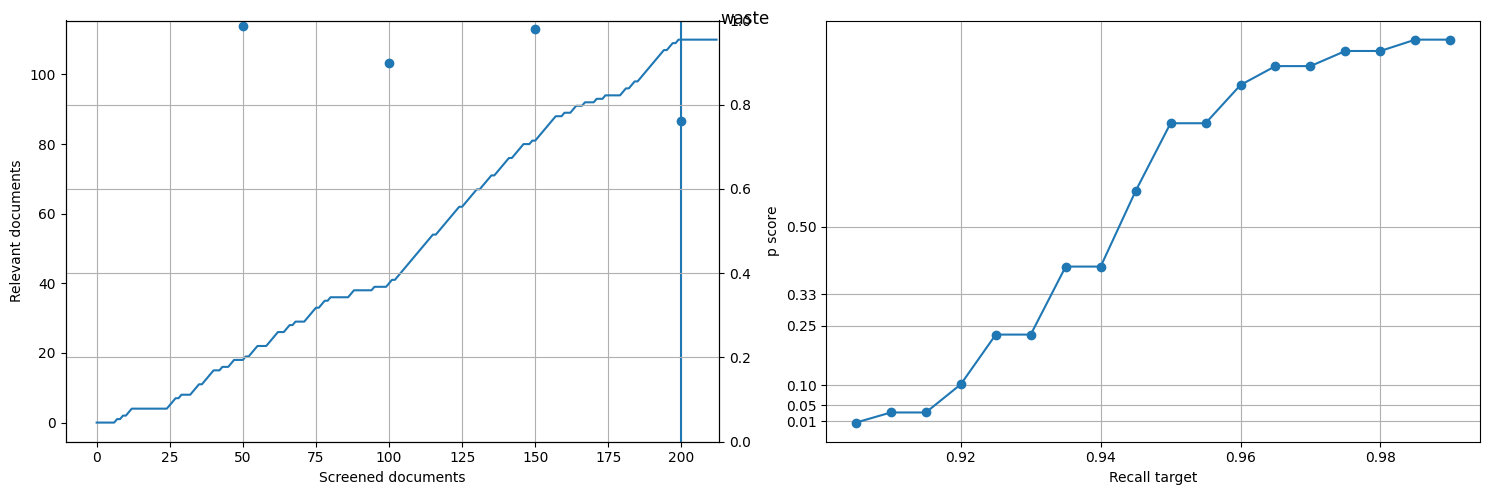

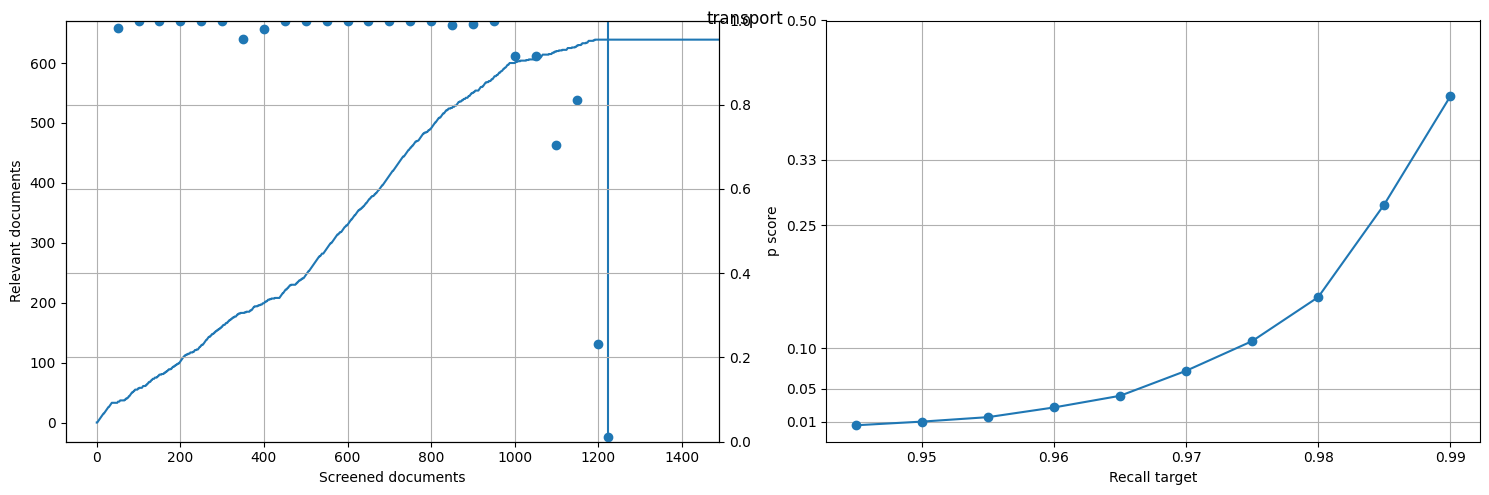

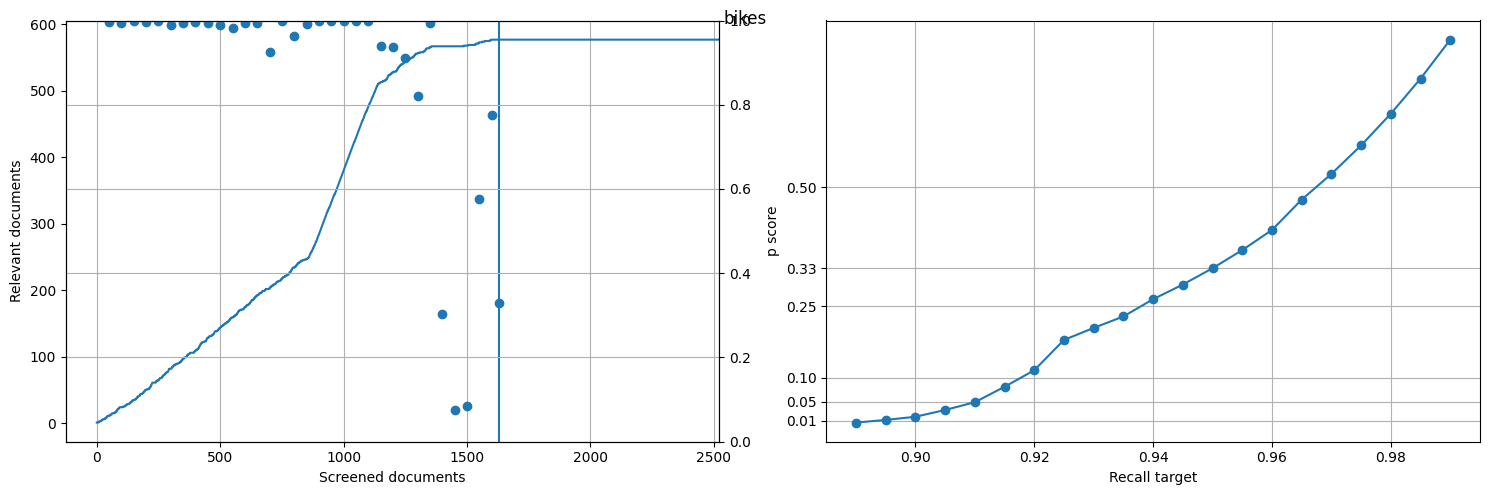

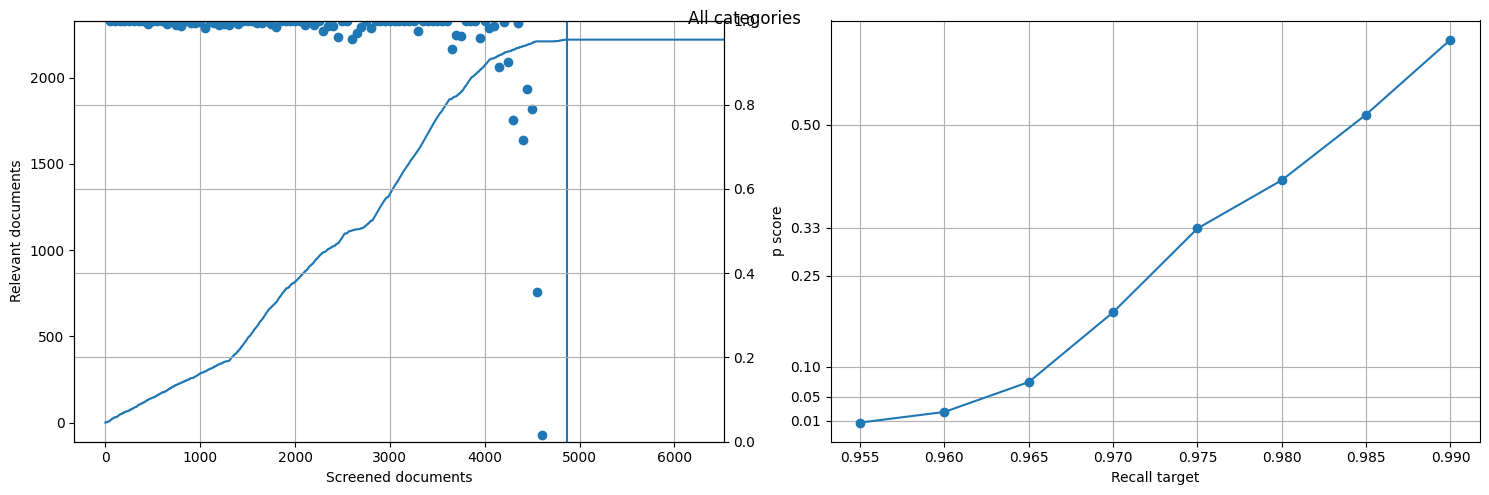

In [56]:
from buscarpy import retrospective_h0, recall_frontier
import matplotlib.pyplot as plt
import tikzplotlib

def fix_nan(y):
    y = np.array(y).astype(float)
    nans = np.isnan(y)
    x = lambda z: z.nonzero()[0]
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return y
    

def plot_h0(sub_df, axs):
    ax = axs[0]
    s_index = pd.notna(sub_df['incl'])
    r_screened = sub_df['incl'].sum()
    ax.plot(fix_nan(sub_df['incl'].cumsum()))
    ax.axvline(fix_nan(s_index.sum()))
    u_index = (pd.isna(sub_df['incl'])) & (sub_df.index > s_index.sum())
    #preds = np.random.binomial(1,sub_df.loc[u_index,'pred_incl|1'], u_index.sum())
    #sub_df.loc[u_index, 'incl'] = preds
    #ax.plot(sub_df.loc[u_index,'incl'].cumsum()+r_screened, color='C0', ls='--')

    ax.set_xlim(xmax=sub_df.shape[0])
    p = retrospective_h0(sub_df['incl'].dropna(), sub_df.shape[0], batch_size=50, plot=False)
    ax2 = ax.twinx()
    ax2.scatter(fix_nan(p['batch_sizes']), fix_nan(p['p']))
    print(fix_nan(p['p']))
    ax2.set_ylim(ymax=1, ymin=0)
    #ax2.set_ylabel('p score')
    ax.set_ylabel('Relevant documents')
    ax.set_xlabel('Screened documents')
    ax.grid(axis='x')
    ax2.grid()

    ax = axs[1]
    r = recall_frontier(sub_df['incl'].dropna(), sub_df.shape[0], plot=False)
    
    ax.plot(fix_nan(r['recall_target']), fix_nan(r['p']), marker='o')
    ax.set_ylabel('p score')
    ax.set_xlabel('Recall target')
    ax.set_yticks([0.01, 0.05, 0.1, 0.25, 0.33, 0.5])
    ax.grid()

def save_tikz(f, a, fname):
    tikzplotlib.clean_figure()
    sep = '2cm'
    n = len(a)
    tikzplotlib.save(fname, 
                     f,
                     #figurewidth=fR'\linewidth/{n} - {n-1}/{n}*{sep}',
                     #figureheight=fR'\linewidth/{n} - {n-1}/{n}*{sep}',
                     #extra_tikzpicture_parameters={'trim axis group left', 'trim axis group right'},
                     #extra_axis_parameters={'scale only axis'},
                     extra_groupstyle_parameters={f'horizontal sep={sep}'})

for name, key, mask in masks:
    print(name, mask.sum())
    sub_df = df[mask].sort_values(['scope_order', 'item_order']).reset_index(drop=True)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    plot_h0(sub_df, axs)
    fig.tight_layout()
    save_tikz(fig, axs, f'figures/{key}.tikz')
    plt.suptitle(name)

sub_df = df.sort_values(['scope_order', 'item_order']).reset_index(drop=True)
fig, axs = plt.subplots(1,2, figsize=(15, 5))
plot_h0(sub_df, axs)
fig.tight_layout()
save_tikz(fig, axs, 'figures/all.tikz')
plt.suptitle('All categories')


In [72]:
print(tikzplotlib.Flavors.latex.preamble())

\documentclass{standalone}
\usepackage[utf8]{inputenc}
\usepackage{pgfplots}
\DeclareUnicodeCharacter{2212}{−}
\usepgfplotslibrary{groupplots,dateplot}
\usetikzlibrary{patterns,shapes.arrows}
\pgfplotsset{compat=newest}



In [36]:
for imp in IMPORTS_UPD.values():
    print(f'{imp}: {df[imp].sum():,}')
for imp in IMPORTS_ORIG.values():
    print(f'{imp}: {df[imp].sum():,}')

Updated Query (11.07.2024) | < 2022 | Bikes: 1,507
Updated Query (11.07.2024) | < 2022 | Buildings: 872
Updated Query (11.07.2024) | < 2022 | Transport: 796
Updated Query (11.07.2024) | < 2022 | Urban form: 582
Updated Query (11.07.2024) | < 2022 | Waste: 103
Updated Query (11.07.2024) | >= 2022 | Waste: 110
Updated Query (11.07.2024) | >= 2022 | Urban form: 496
Updated Query (11.07.2024) | >= 2022 | Transport: 694
Updated Query (11.07.2024) | >= 2022 | Buildings: 585
Updated Query (11.07.2024) | >= 2022 | Bikes: 1,016
Original data (bikes and scooters): 1,325
Original data (buildings): 646
Original data (transport): 530
Original data (urban form): 330
Original data (waste): 121


In [43]:
QUERIES = [
    ('Bikes', 'Original data (bikes and scooters)', 'Updated Query (11.07.2024) | < 2022 | Bikes', 'Updated Query (11.07.2024) | >= 2022 | Bikes'),
    ('Buildings', 'Original data (buildings)', 'Updated Query (11.07.2024) | < 2022 | Buildings', 'Updated Query (11.07.2024) | >= 2022 | Buildings'),
    ('Transport', 'Original data (transport)', 'Updated Query (11.07.2024) | < 2022 | Transport', 'Updated Query (11.07.2024) | >= 2022 | Transport',),
    ('Urban form', 'Original data (urban form)', 'Updated Query (11.07.2024) | < 2022 | Urban form', 'Updated Query (11.07.2024) | >= 2022 | Urban form',),
    ('Waste', 'Original data (waste)', 'Updated Query (11.07.2024) | < 2022 | Waste', 'Updated Query (11.07.2024) | >= 2022 | Waste'),
]
print('Name | Original | Updated < 2022 | Updated >= 2022 | Updated | Orig AND Upd | Orig OR Upd')
acc = []
for name, old, pre, post in QUERIES:
    acc.append({
        'Name': name,
        'Original': df[old].sum(),
        'Updated < 2022': df[pre].sum(),
        'Updated >= 2022': df[post].sum(),
        'Updated': (df[pre].astype(bool) | df[post].astype(bool)).sum(),
        'Orig AND Upd': (df[old].astype(bool) & (df[pre].astype(bool) | df[post].astype(bool))).sum(),
        'Orig OR Upd': (df[old].astype(bool) | (df[pre].astype(bool) | df[post].astype(bool))).sum()
    })
    
    print(f'{name}: {df[old].sum():,} '
          f'| {df[pre].sum():,} '
          f'| {df[post].sum():,} '
          f'| {(df[pre].astype(bool) | df[post].astype(bool)).sum():,} '
          f'| {(df[old].astype(bool) & (df[pre].astype(bool) | df[post].astype(bool))).sum():,} '
          f'| {(df[old].astype(bool) | (df[pre].astype(bool) | df[post].astype(bool))).sum():,}')
pd.DataFrame(acc)

Name | Original | Updated < 2022 | Updated >= 2022 | Updated | Orig AND Upd | Orig OR Upd
Bikes: 1,325 | 1,507 | 1,016 | 2,523 | 873 | 2,975
Buildings: 646 | 872 | 585 | 1,457 | 503 | 1,600
Transport: 530 | 796 | 694 | 1,490 | 399 | 1,621
Urban form: 330 | 582 | 496 | 1,078 | 265 | 1,143
Waste: 121 | 103 | 110 | 213 | 110 | 224


Name  Original  Updated < 2022  Updated >= 2022  Updated  \
0       Bikes      1325            1507             1016     2523   
1   Buildings       646             872              585     1457   
2   Transport       530             796              694     1490   
3  Urban form       330             582              496     1078   
4       Waste       121             103              110      213   

   Orig AND Upd  Orig OR Upd  
0           873         2975  
1           503         1600  
2           399         1621  
3           265         1143  
4           110          224

In [61]:
mask_incl = df['incl'] == 1
mask_excl = df['incl'] == 0

print(f'% Screened in total: {mask_seen.sum():,}')
print(f'% Included in total: {mask_incl.sum():,} / excluded: {mask_excl.sum():,}')
print(f'% Original data | screened: {(mask_old & mask_seen).sum():,} / included: {(mask_old & mask_incl).sum():,} / excluded: {(mask_old & mask_excl).sum():,}')
print(f'% New data | screened: {(mask_new & mask_seen).sum():,} / included: {(mask_new & mask_incl).sum():,} / excluded: {(mask_new & mask_excl).sum():,}')
print(f'% Novel data | screened: {(mask_novel & mask_seen).sum():,} / included: {(mask_novel & mask_incl).sum():,} / excluded: {(mask_novel & mask_excl).sum():,}')

for name, old, pre, post in QUERIES:
    print('% ----------------------')
    print('%', name)
    print('% ----------------------')
    msk = df[old].astype(bool) | df[pre].astype(bool) | df[post].astype(bool)
    print(f'% Screened in total: {(msk & mask_seen).sum():,}')
    print(f'% Included in total: {(msk & mask_incl).sum():,} / excluded: {(msk & mask_excl).sum():,}')
    print(f'% Original data | screened: {(msk & mask_old & mask_seen).sum():,} / included: {(msk & mask_old & mask_incl).sum():,} / excluded: {(msk & mask_old & mask_excl).sum():,}')
    print(f'% New data | screened: {(msk & mask_new & mask_seen).sum():,} / included: {(msk & mask_new & mask_incl).sum():,} / excluded: {(msk & mask_new & mask_excl).sum():,}')
    print(f'% Novel data | screened: {(msk & mask_novel & mask_seen).sum():,} / included: {(msk & mask_novel & mask_incl).sum():,} / excluded: {(msk & mask_novel & mask_excl).sum():,}')

% Screened in total: 4,880
% Included in total: 2,220 / excluded: 2,650
% Original data | screened: 2,823 / included: 1,177 / excluded: 1,646
% New data | screened: 4,160 / included: 1,966 / excluded: 2,184
% Novel data | screened: 2,057 / included: 1,043 / excluded: 1,004
% ----------------------
% Bikes
% ----------------------
% Screened in total: 2,081
% Included in total: 689 / excluded: 1,390
% Original data | screened: 1,349 / included: 394 / excluded: 955
% New data | screened: 1,632 / included: 577 / excluded: 1,053
% Novel data | screened: 732 / included: 295 / excluded: 435
% ----------------------
% Buildings
% ----------------------
% Screened in total: 1,393
% Included in total: 902 / excluded: 485
% Original data | screened: 718 / included: 470 / excluded: 248
% New data | screened: 1,266 / included: 819 / excluded: 441
% Novel data | screened: 675 / included: 432 / excluded: 237
% ----------------------
% Transport
% ----------------------
% Screened in total: 1,358
% I